In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from functions import *
from models import *
import tensorflow as tf
from livelossplot import PlotLossesKeras
os.environ["CUDA_VISIBLE_DEVICES"] = "1" # pick a number < 4 on ML4HEP; < 3 on Voltan 
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2022-01-26 15:36:37.511273: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-01-26 15:36:37.534077: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:41:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-01-26 15:36:37.534231: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-01-26 15:36:37.535542: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-01-26 15:36:37.537166: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-01-26 15:36:37.537389: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2

In [3]:
stream = "gd1_tail"

In [4]:
df, file = load_file(stream = stream, percent_bkg = 100)

### Optional: Exclude a hotspot

In [ ]:
# plt.figure(figsize=(3,3),dpi=150)
# hist = plt.hist2d(df.α, df.δ, bins=20)
# plt.xlabel(r'$\alpha$ [\textdegree]');
# plt.ylabel(r'$\delta$ [\textdegree]');

In [ ]:
# # Get indices for hotspot bin to exclude
# i, j = np.unravel_index(hist[0].argmax(), hist[0].shape)

# # Exclude this bin based on bin edges 
# df2 = df[(df.α < hist[1][i]) | (df.α > hist[1][i+1]) | 
#          (df.δ < hist[1][j]) | (df.δ > hist[1][j+1])]

# print("{:.1f}% of the dataset remains.".format(100*len(df2)/len(df)))

# # Redefine dataframe
# df = df2

### Prepare datasets for training

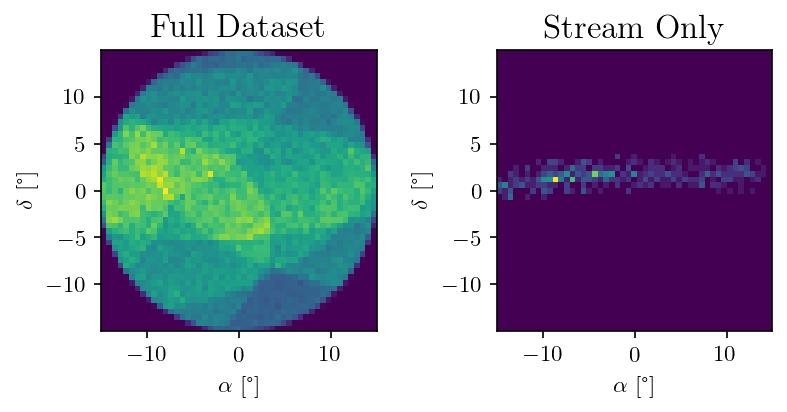

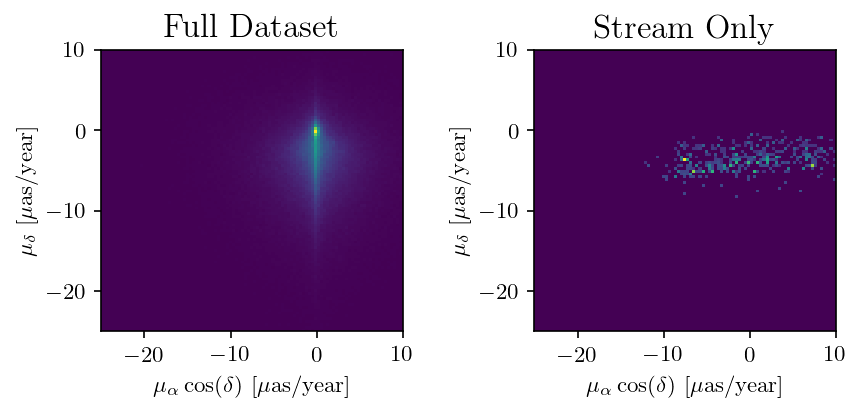

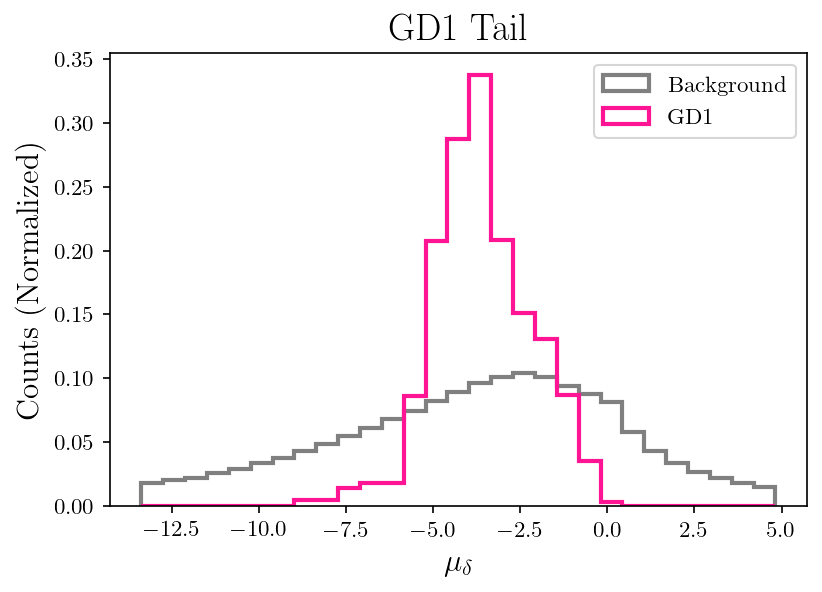

In [5]:
visualize_stream(df)

Sideband region: [-7.0,-3.0]
Signal region: [-6.0,-3.1]
Total counts: SR = 613,810, SB = 181,912


/clusterfs/ml4hep/mpettee/GaiaCWoLa/functions.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_slice['label'] = np.where(((df_slice.μ_δ > sr_min) & (df_slice.μ_δ < sr_max)), 1, 0)
No handles with labels found to put in legend.


Signal region has 1,565 stream and 612,245 bkg events (0.26%).
Sideband region has 94 stream and 181,818 bkg events (0.05%).
f_sig = 4.9X f_sideband.


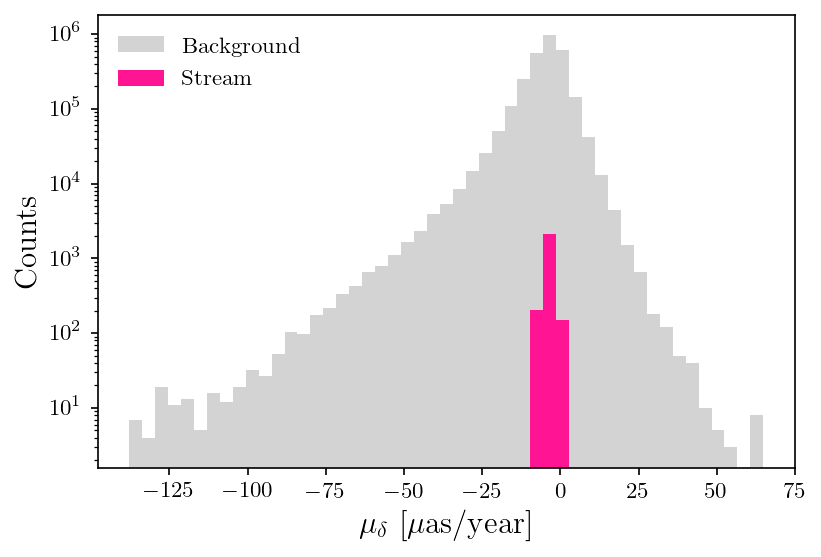

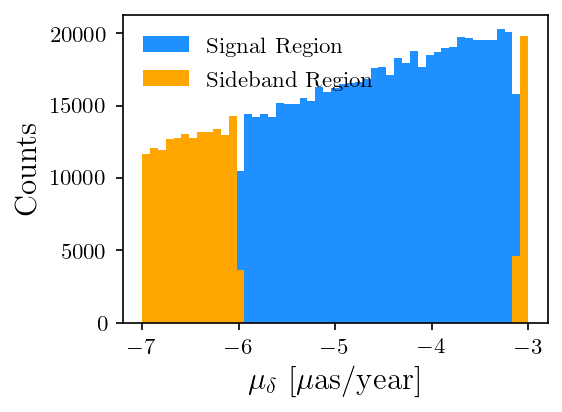

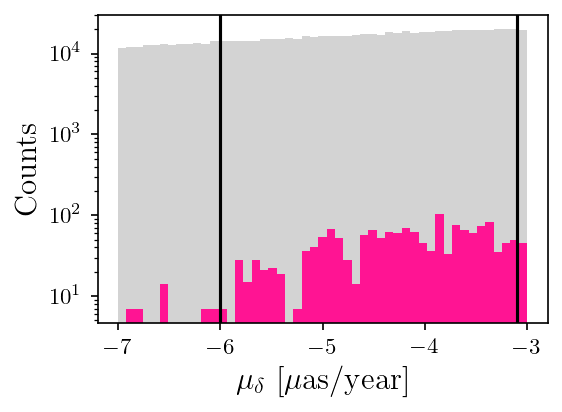

In [6]:
df = signal_sideband(df, stream = stream)

Add sample weights to stream stars:

In [7]:
stream_weight = 1

### Throughout signal & sideband regions
df["weight"] = np.where(df['stream'] == True, stream_weight, 1)

In [8]:
df.weight.value_counts()

1    795722
Name: weight, dtype: int64

# Train

In [9]:
tf.keras.backend.clear_session()

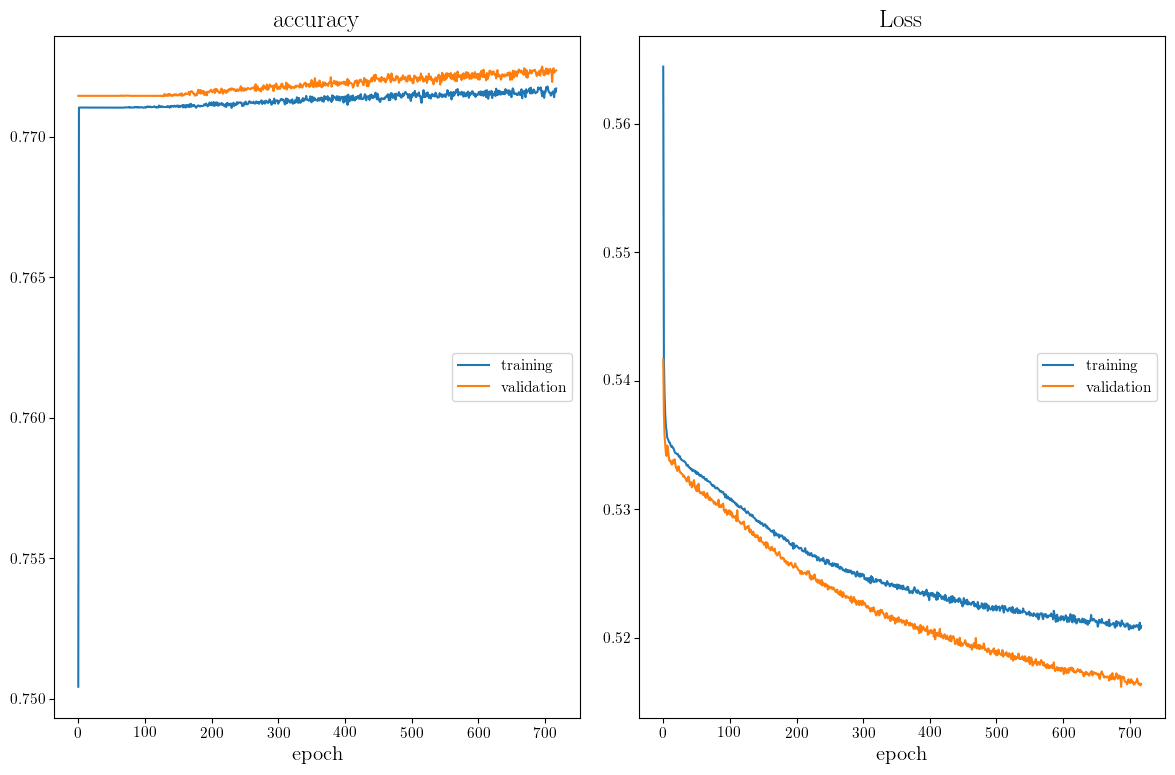

accuracy
	training         	 (min:    0.750, max:    0.772, cur:    0.772)
	validation       	 (min:    0.771, max:    0.772, cur:    0.772)
Loss
	training         	 (min:    0.521, max:    0.564, cur:    0.521)
	validation       	 (min:    0.516, max:    0.542, cur:    0.516)
56/56 [==============================] - 0s 7ms/step - loss: 0.5209 - accuracy: 0.7717 - val_loss: 0.5164 - val_accuracy: 0.7724
Best losses: [0.5206092000007629]
Loading weights from best loop, i.e. loop #0.
AUC: 0.636
Maximum purity of 30.8% at 0.01%
Top 10 stars: Purity = 30.0% 
Top 20 stars: Purity = 40.0% 
Top 50 stars: Purity = 52.0% 
Top 100 stars: Purity = 43.0% 


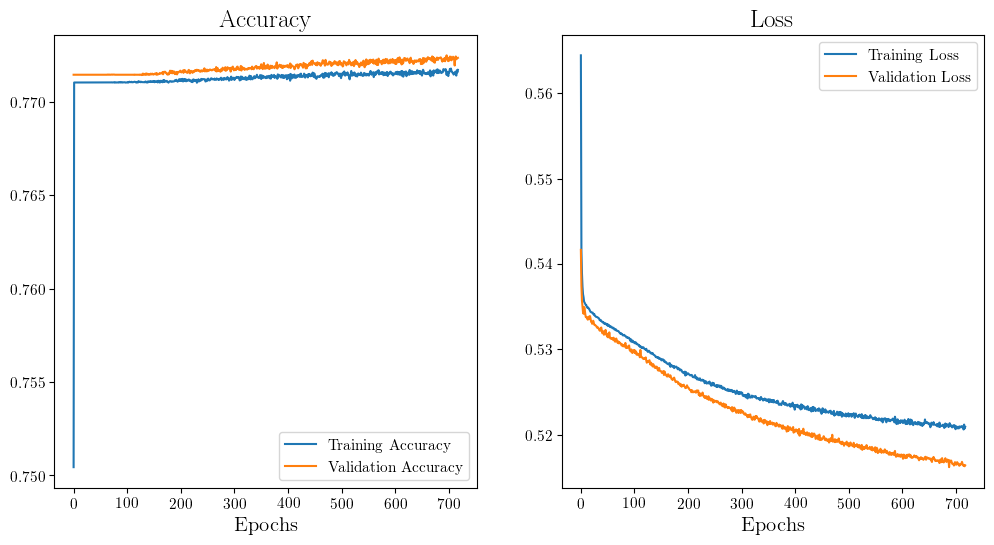

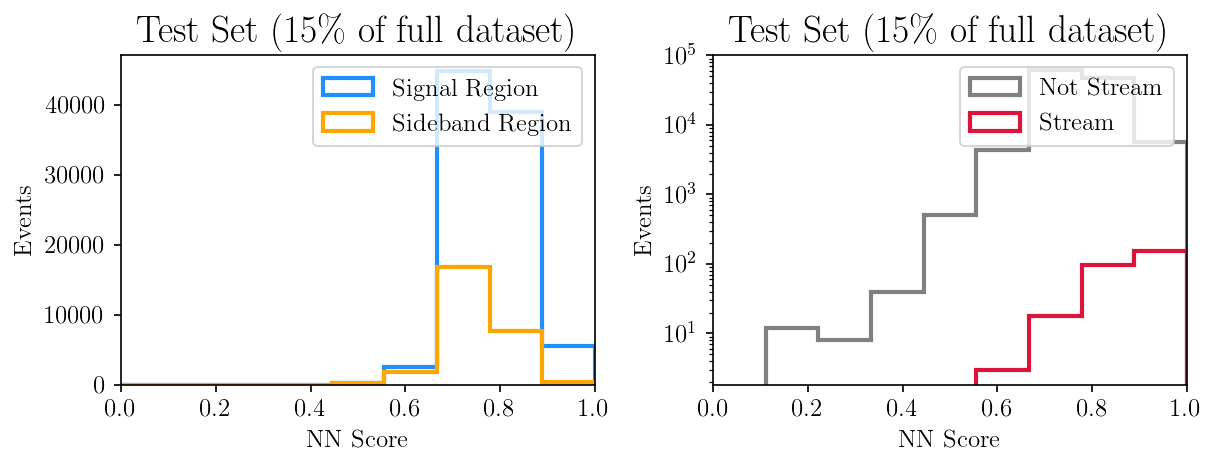

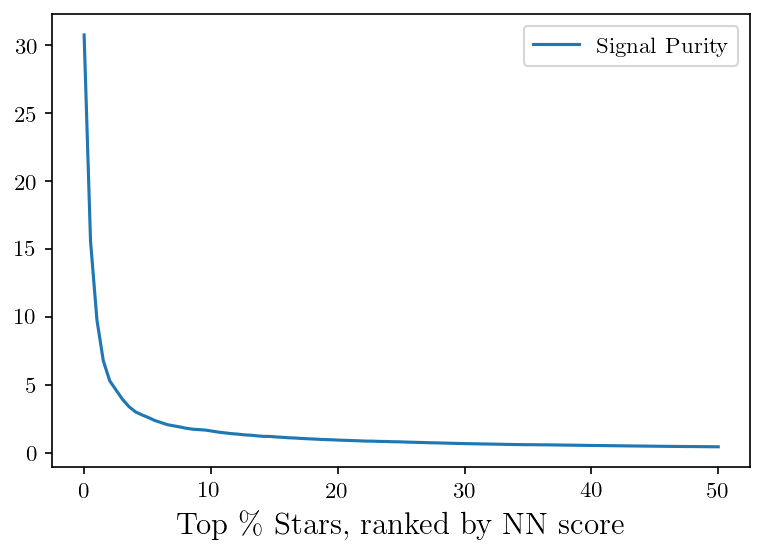

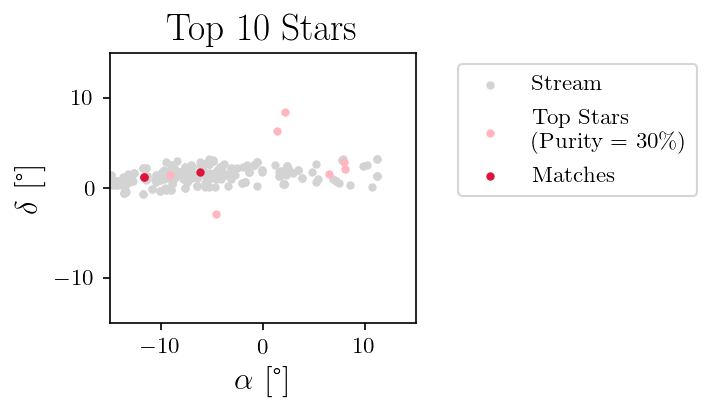

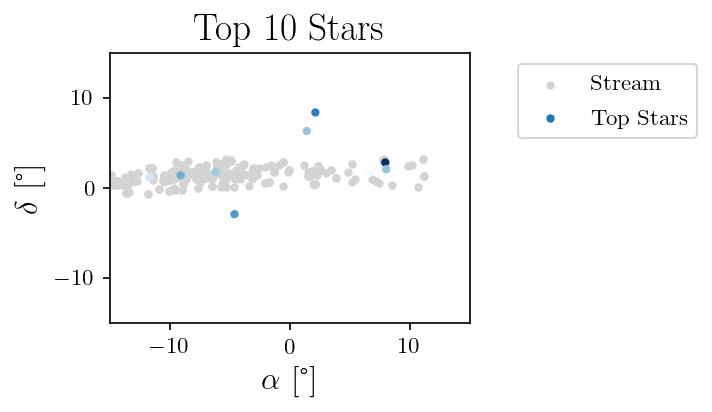

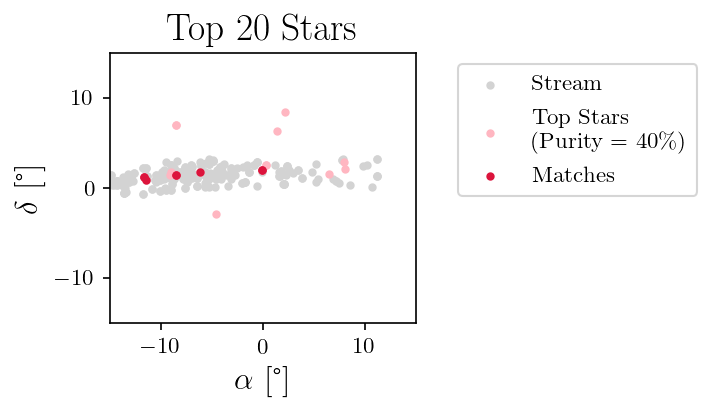

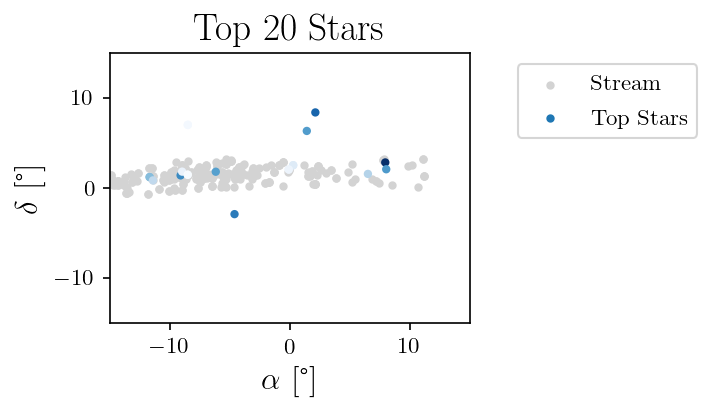

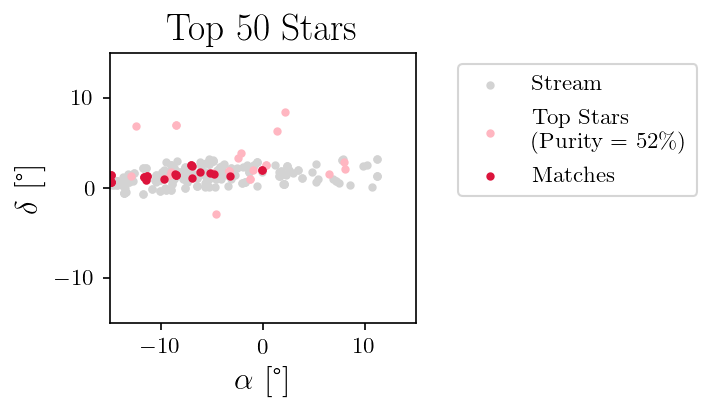

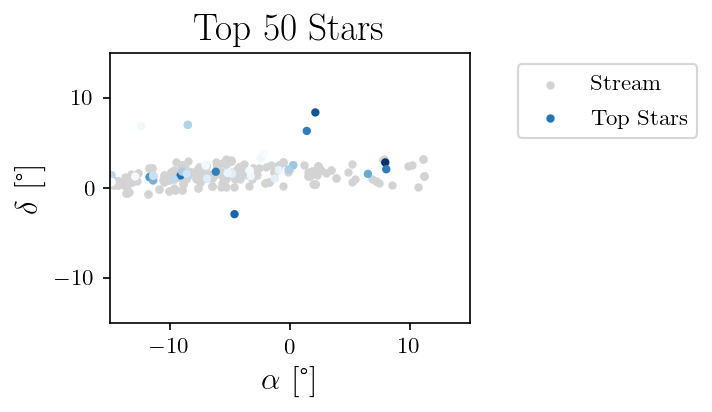

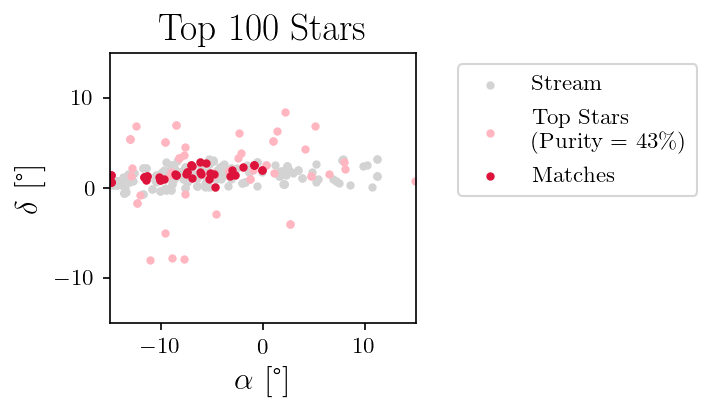

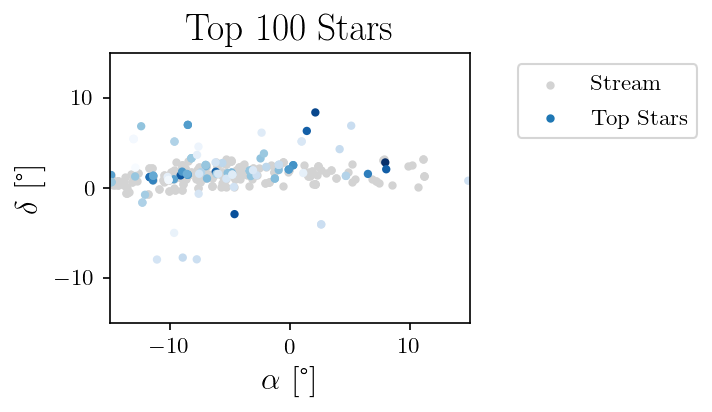

In [10]:
test = train(df, 
      n_folds = 1, 
      best_of_n_loops = 1,
      layer_size = 128, 
      batch_size = 10000, 
      dropout = 0.2, 
      epochs = 2000, 
      patience = 30)